# Tugas Eksplorasi ResNet Kelompok 13 NGASAL
Mata Kuliah: Pembelajaran Mendalam (IF25-40401) RA 
Program Studi Teknik Informatika – Institut Teknologi Sumatera
### Nama Anggota Kelompok:
- Bayu Prameswara Haris - 122140219
- Jason Surya Padantya - 122140237
- Abu Bakar Siddiq Siregar - 122140164


## 1. Instalasi Dependensi

In [ ]:
import os, json
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import classification_report

## 2. Konfigurasi

In [ ]:
IMG_PATH = "train"  
CSV_PATH = "train.csv"
BATCH_SIZE = 8
EPOCHS = 15       
LR = 1e-3         
Random_Seed = 42  

## 3. Data Loader

In [ ]:
class FoodDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {
            "gado_gado": 0,
            "bakso": 1,
            "rendang": 2,
            "nasi_goreng": 3,
            "soto_ayam": 4
        }
        self.idx_to_class = {v: k for k, v in self.label_map.items()}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.label_map[self.data.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = FoodDataset(csv_file=CSV_PATH, root_dir=IMG_PATH, transform=transform)
generator = torch.Generator().manual_seed(Random_Seed)  
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


## 4. Modifikasi Model

In [6]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, 1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=5):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes*block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes*block.expansion)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x); x = self.bn1(x); x = self.relu(x); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# D: Pre-activation Block
class PreActBasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(PreActBasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.downsample = downsample

    def forward(self, x):
        out = self.relu(self.bn1(x))
        shortcut = x
        if self.downsample is not None:
            shortcut = self.downsample(out)
        out = self.conv1(out)
        out = self.conv2(self.relu(self.bn2(out)))
        out += shortcut
        return out

# E: Kernel/Stride Modified Block
class KernelModifiedBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(KernelModifiedBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=5, stride=stride, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

## 5. Builder

In [7]:
def resnet34(num_classes=5):
    return ResNet(BasicBlock, [3,4,6,3], num_classes=num_classes)

def preact_resnet34(num_classes=5):
    return ResNet(PreActBasicBlock, [3,4,6,3], num_classes=num_classes)

def kernel_resnet34(num_classes=5):
    return ResNet(KernelModifiedBlock, [3,4,6,3], num_classes=num_classes)

## 6. Training Utilities

In [ ]:
criterion = nn.CrossEntropyLoss()

def run_epoch(model, loader, optimizer=None):
    train = optimizer is not None
    model.train() if train else model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.set_grad_enabled(train):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            if train:
                optimizer.zero_grad(); loss.backward(); optimizer.step()
            running_loss += loss.item()
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()
    return running_loss / len(loader), 100.0 * correct / total

def evaluate_classification_report(model, loader, class_names):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    report = classification_report(
        y_true, y_pred, target_names=class_names, digits=2
    )
    print(report)

## 7. Latih semua model (Std, PreAct, Kernel)

In [ ]:
models = {
    "resnet34_std": resnet34(num_classes=5).to(device),
    "resnet34_preact": preact_resnet34(num_classes=5).to(device),
    "resnet34_kernel": kernel_resnet34(num_classes=5).to(device)
}

class_names = ["gado_gado", "bakso", "rendang", "nasi_goreng", "soto_ayam"]

for name, model in models.items():
    print(f"\n=== Training {name} ===")
    optimizer = optim.Adam(model.parameters(), lr=LR)
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(EPOCHS):
        tr_loss, tr_acc = run_epoch(model, train_loader, optimizer)
        va_loss, va_acc = run_epoch(model, val_loader)
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)
        print(f"Epoch {epoch+1}/{EPOCHS} | Train {tr_acc:.2f}% | Val {va_acc:.2f}%")

    # Simpan model & history
    torch.save(model.state_dict(), f"{name}.pth")
    np.savez(f"{name}_history.npz",
             train_loss=np.array(history["train_loss"]),
             val_loss=np.array(history["val_loss"]),
             train_acc=np.array(history["train_acc"]),
             val_acc=np.array(history["val_acc"]),
             meta=np.array([json.dumps({
                 "batch_size": BATCH_SIZE,
                 "epochs": EPOCHS,
                 "lr": LR,
                 "optimizer": "adam",
                 "split":"80/20",
                 "seed": Random_Seed
             })], dtype=object))
    print(f"Saved: {name}.pth & {name}_history.npz")

    # Classification report
    print(f"\n=== Classification Report for {name} ===")
    evaluate_classification_report(model, val_loader, class_names)

def load_history(name):
    h = np.load(f"{name}_history.npz", allow_pickle=True)
    return {
        "train_loss": h["train_loss"].tolist(),
        "val_loss": h["val_loss"].tolist(),
        "train_acc": h["train_acc"].tolist(),
        "val_acc": h["val_acc"].tolist(),
    }

hist_std    = load_history("resnet34_std")
hist_preact = load_history("resnet34_preact")
hist_kernel = load_history("resnet34_kernel")


\n=== Training resnet34_std ===


d:\Alat program\SupportSystem\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10 | Train 38.37% | Val 24.77%
Epoch 2/10 | Train 44.24% | Val 51.35%
Epoch 3/10 | Train 48.87% | Val 37.84%
Epoch 4/10 | Train 54.18% | Val 40.54%
Epoch 5/10 | Train 54.18% | Val 64.86%
Epoch 6/10 | Train 56.21% | Val 59.01%
Epoch 7/10 | Train 59.59% | Val 51.35%
Epoch 8/10 | Train 62.08% | Val 59.01%
Epoch 9/10 | Train 65.35% | Val 62.16%
Epoch 10/10 | Train 64.67% | Val 61.71%
Saved: resnet34_std.pth & resnet34_std_history.npz
\n=== Training resnet34_preact ===
Epoch 1/10 | Train 28.44% | Val 31.08%
Epoch 2/10 | Train 31.72% | Val 28.83%
Epoch 3/10 | Train 34.31% | Val 39.64%
Epoch 4/10 | Train 37.81% | Val 45.95%
Epoch 5/10 | Train 39.73% | Val 51.35%
Epoch 6/10 | Train 44.58% | Val 43.24%
Epoch 7/10 | Train 43.00% | Val 44.14%
Epoch 8/10 | Train 45.71% | Val 33.78%
Epoch 9/10 | Train 46.95% | Val 49.10%
Epoch 10/10 | Train 47.52% | Val 34.23%
Saved: resnet34_preact.pth & resnet34_preact_history.npz
\n=== Training resnet34_kernel ===
Epoch 1/10 | Train 34.99% | Val 45.50%
E

In [3]:
def load_history(name):
    h = np.load(f"{name}_history.npz", allow_pickle=True)
    return {
        "train_loss": h["train_loss"].tolist(),
        "val_loss": h["val_loss"].tolist(),
        "train_acc": h["train_acc"].tolist(),
        "val_acc": h["val_acc"].tolist(),
    }

hist_std    = load_history("resnet34_std")
hist_preact = load_history("resnet34_preact")
hist_kernel = load_history("resnet34_kernel")


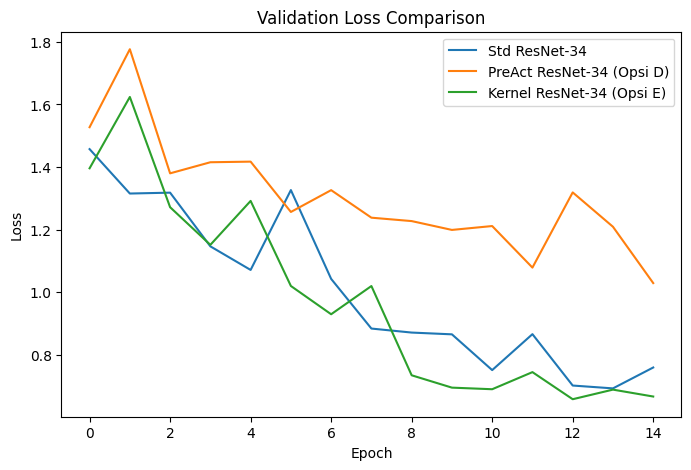

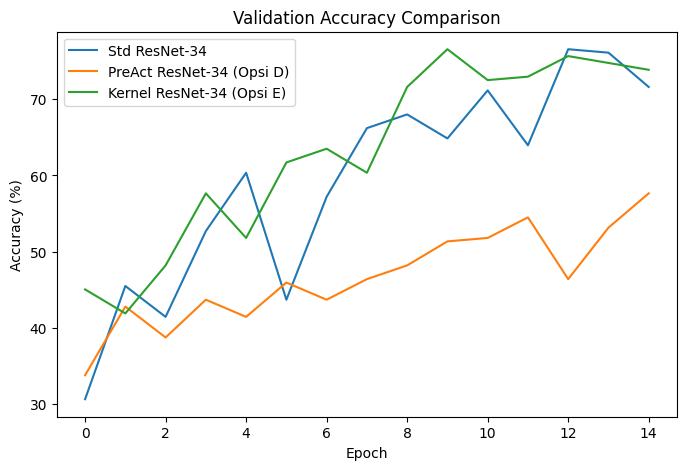

In [4]:
# Val Loss comparison
plt.figure(figsize=(8,5))
plt.plot(hist_std["val_loss"], label="Std ResNet-34")
plt.plot(hist_preact["val_loss"], label="PreAct ResNet-34 (Opsi D)")
plt.plot(hist_kernel["val_loss"], label="Kernel ResNet-34 (Opsi E)")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Validation Loss Comparison")
plt.legend(); plt.show()

# Val Accuracy comparison
plt.figure(figsize=(8,5))
plt.plot(hist_std["val_acc"], label="Std ResNet-34")
plt.plot(hist_preact["val_acc"], label="PreAct ResNet-34 (Opsi D)")
plt.plot(hist_kernel["val_acc"], label="Kernel ResNet-34 (Opsi E)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Comparison")
plt.legend(); plt.show()


In [5]:
summary = {
    "Model": ["Std ResNet-34", "PreAct ResNet-34", "Kernel ResNet-34"],
    "Train Loss": [hist_std["train_loss"][-1], hist_preact["train_loss"][-1], hist_kernel["train_loss"][-1]],
    "Val Loss":   [hist_std["val_loss"][-1],   hist_preact["val_loss"][-1],   hist_kernel["val_loss"][-1]],
    "Train Acc %": [hist_std["train_acc"][-1], hist_preact["train_acc"][-1], hist_kernel["train_acc"][-1]],
    "Val Acc %":   [hist_std["val_acc"][-1],   hist_preact["val_acc"][-1],   hist_kernel["val_acc"][-1]]
}

df = pd.DataFrame(summary)
print(df.to_string(index=False))


           Model  Train Loss  Val Loss  Train Acc %  Val Acc %
   Std ResNet-34    0.868399  0.758956    68.171558  71.621622
PreAct ResNet-34    1.148701  1.028783    53.386005  57.657658
Kernel ResNet-34    0.789286  0.666172    70.880361  73.873874
